In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, kernel
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')

In [44]:
data_stdp = data[data['ptl_idx'].isin([1,2,3,4])]

In [48]:
data_stdp['train_len'].max()

60.0

In [40]:
data_stdp.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


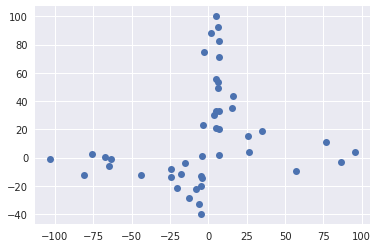

In [9]:
data_stdp = data[data['ptl_idx']==1]
plt.plot(data_stdp['dt1'], data_stdp['dw_mean'], 'o')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


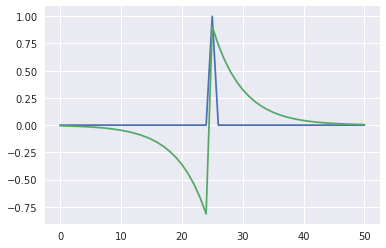

In [34]:
kernel_test = kernel.KernelGen()
plt.plot(kernel_test.dot_ker)
plt.plot(kernel_test.bilat_ker)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


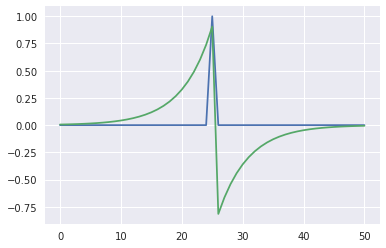

In [31]:
with tf.Graph().as_default():
    
    x = tf.placeholder(shape=[51,1], dtype=tf.float32)
    kernel = tf.placeholder(shape=[51, 1], dtype=tf.float32)
    
    x_exp = tf.expand_dims(x, 0)
    kernel_exp = tf.expand_dims(kernel, 2)
    y = tf.squeeze(tf.nn.conv1d(value=x_exp, filters=kernel_exp, stride=1, padding='SAME'))
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        x_out, y_out = sess.run([x, y], feed_dict={x: kernel_test.dot_ker, kernel: kernel_test.bilat_ker})
        
plt.plot(x_out)
plt.plot(y_out)